In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities


# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, box_size, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + compute_lennard_jones_forces(positions, box_size)
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different k values
k_values = np.linspace(1.0, 2.0, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for k in k_values:
    # Re-initialize positions and velocities for each k value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()


TypeError: velocity_verlet() missing 1 required positional argument: 'k'

In [16]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              1.0000     3.6788     0.4207
              1.1111     4.8984     0.3421
              1.2222     5.4698     0.2335
              1.3333     4.1217     0.4870
              1.4444     4.5479     0.3920
              1.5556     4.5308     0.1830
              1.6667     3.9034     0.2417
              1.7778     4.6845     0.3840
              1.8889     3.9295     0.4052
              2.0000     3.7849     0.4004

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              1.0000     8.8119     1.6219
              1.1111    13.8631     1.6668
              1.2222    16.2718     1.2844
              1.3333    11.0785     2.2863
              1.4444    12.6811     1.4725
              1.5556    13.0821     1.0377
              1.6667    10.6438     0.9809
              1.7778    13.5053     1.6108
              1.8889    10.7080     1.2642
           

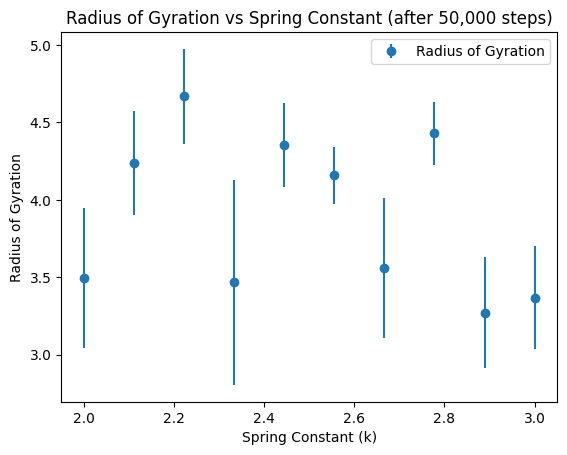

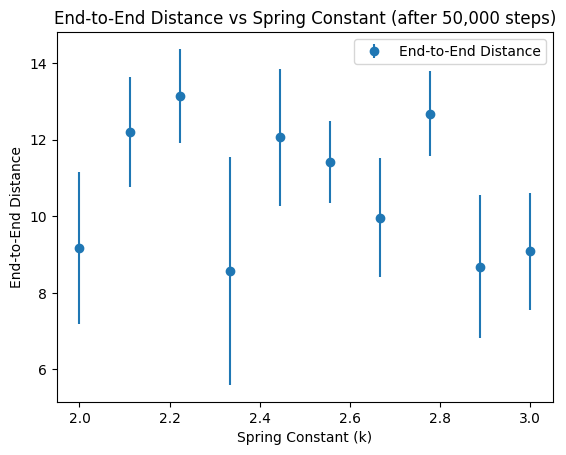

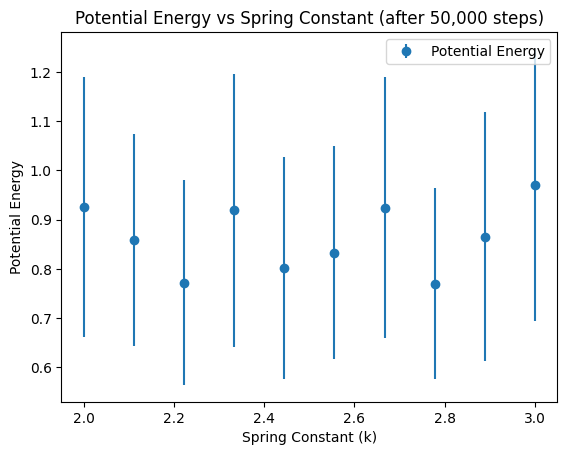

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different k values
k_values = np.linspace(2.0, 3.0, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for k in k_values:
    # Re-initialize positions and velocities for each k value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()


In [18]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              2.0000     3.4965     0.4502
              2.1111     4.2366     0.3376
              2.2222     4.6670     0.3068
              2.3333     3.4671     0.6616
              2.4444     4.3552     0.2703
              2.5556     4.1586     0.1842
              2.6667     3.5595     0.4525
              2.7778     4.4294     0.2032
              2.8889     3.2705     0.3578
              3.0000     3.3684     0.3320

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              2.0000     9.1665     1.9789
              2.1111    12.2124     1.4385
              2.2222    13.1428     1.2302
              2.3333     8.5772     2.9840
              2.4444    12.0624     1.7884
              2.5556    11.4131     1.0674
              2.6667     9.9652     1.5534
              2.7778    12.6854     1.1023
              2.8889     8.6839     1.8718
           

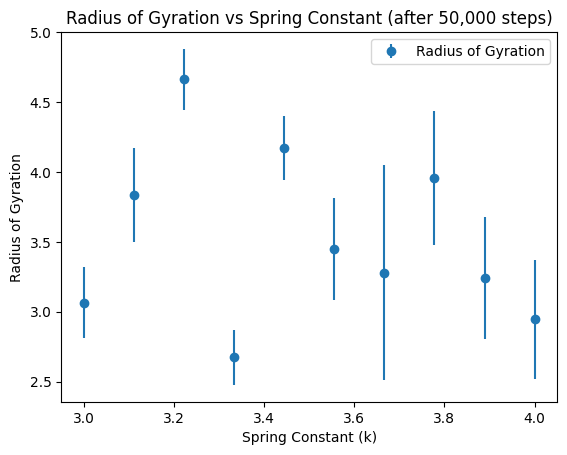

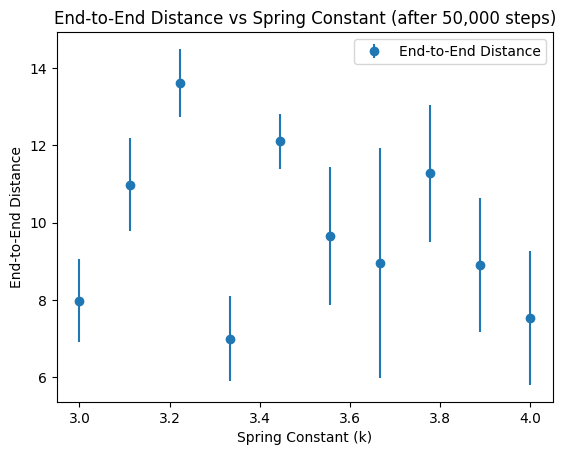

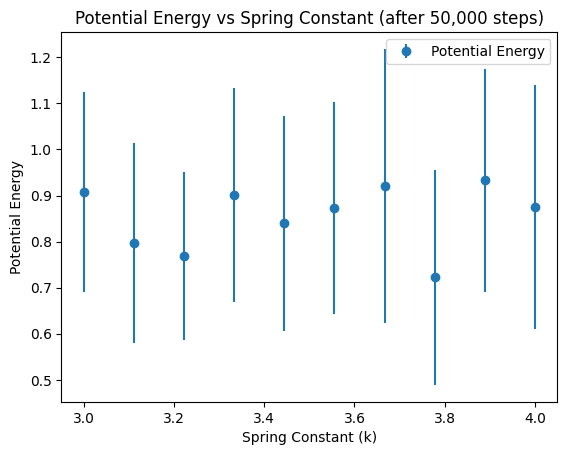

In [19]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different k values
k_values = np.linspace(3.0, 4.0, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for k in k_values:
    # Re-initialize positions and velocities for each k value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()


In [20]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              3.0000     3.0660     0.2555
              3.1111     3.8374     0.3376
              3.2222     4.6647     0.2170
              3.3333     2.6726     0.1963
              3.4444     4.1721     0.2259
              3.5556     3.4526     0.3654
              3.6667     3.2800     0.7673
              3.7778     3.9567     0.4802
              3.8889     3.2389     0.4367
              4.0000     2.9479     0.4262

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              3.0000     7.9815     1.0741
              3.1111    10.9811     1.2085
              3.2222    13.6126     0.8828
              3.3333     6.9989     1.1062
              3.4444    12.1034     0.7117
              3.5556     9.6560     1.7791
              3.6667     8.9515     2.9752
              3.7778    11.2798     1.7771
              3.8889     8.9036     1.7335
           

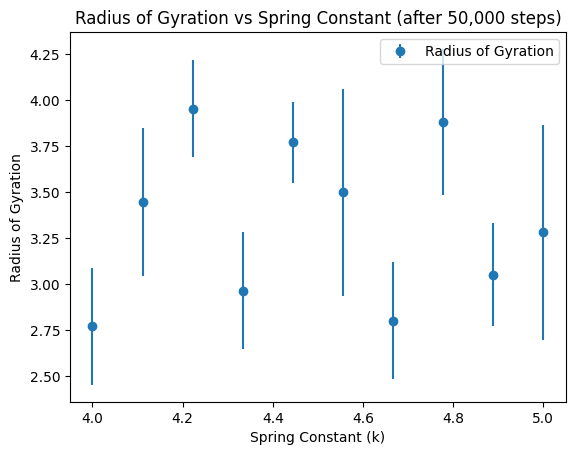

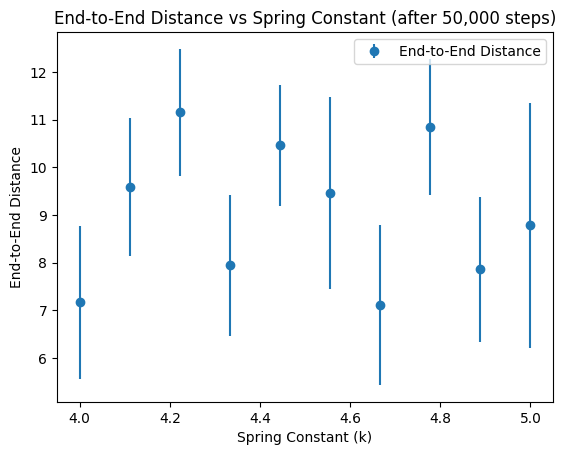

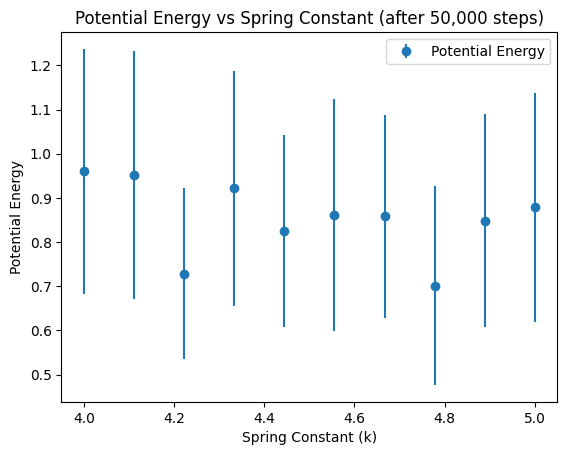

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
dt = 0.01  # Time step
total_steps = 60000  # Number of steps (20,000 in total)
box_size = 100.0  # Size of the cubic box
mass = 1.0  # Particle mass
r0 = 1.0  # Equilibrium bond length
target_temperature = 0.1  # Target temperature (fixed)
rescale_interval = 100  # Steps between velocity rescaling
n_particles = 20  # Number of particles
epsilon_repulsive = 1.0  # Depth of repulsive LJ potential (fixed)
epsilon_attractive = 0.5  # Depth of attractive LJ potential
sigma = 1.0  # LJ potential parameter
cutoff = 1e-6 * sigma  # Reduce cutoff to limit attraction range
k_B = 1.0  # Boltzmann constant

# Initialize Positions and Velocities
def initialize_chain(n_particles, box_size, r0):
    positions = np.zeros((n_particles, 3))
    current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
    positions[0] = current_position
    for i in range(1, n_particles):
        direction = np.random.randn(3)
        direction /= np.linalg.norm(direction)
        next_position = current_position + r0 * direction
        positions[i] = next_position % box_size
        current_position = positions[i]
    return positions

def initialize_velocities(n_particles, target_temperature, mass):
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities

# Apply Periodic Boundary Conditions
def apply_pbc(position, box_size):
    return position % box_size

# Compute Forces
def minimum_image(displacement, box_size):
    return displacement - box_size * np.round(displacement / box_size)

# Harmonic Forces
def compute_harmonic_forces(positions, k, r0, box_size):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

# Lennard-Jones Forces
def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_value = epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_value = epsilon_attractive
            else:
                continue
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            if distance < cutoff:
                force_magnitude = 24 * epsilon_value * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k):
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size) + \
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
                 compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass):
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# Analysis Functions
def calculate_radius_of_gyration(positions):
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    Rg = np.sqrt(Rg_squared)
    return Rg

def calculate_end_to_end_distance(positions):
    Ree = np.linalg.norm(positions[-1] - positions[0])
    return Ree

# Arrays to store results for different k values
k_values = np.linspace(4.0, 5.0, 10)
mean_Rg_values = []
std_Rg_values = []
mean_Ree_values = []
std_Ree_values = []
mean_potential_energies = []
std_potential_energies = []

for k in k_values:
    # Re-initialize positions and velocities for each k value
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, target_temperature, mass)
    forces = compute_harmonic_forces(positions, k, r0, box_size) + \
             compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, 'repulsive') + \
             compute_lennard_jones_forces(positions, epsilon_attractive, sigma, box_size, 'attractive')

    # Arrays to store properties during each step after 50,000 steps
    Rg_values = []
    Ree_values = []
    potential_energies = []

    # Run simulation loop
    for step in range(total_steps):
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k)
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, target_temperature, mass)

        # Store values only after step 50,000
        if step >= 50000:
            # Compute properties for this step
            Rg = calculate_radius_of_gyration(positions)
            Ree = calculate_end_to_end_distance(positions)

            # Calculate potential energy
            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

            E_LJ = 0.0
            for i in range(n_particles - 1):
                for j in range(i + 1, n_particles):
                    displacement = positions[j] - positions[i]
                    displacement = minimum_image(displacement, box_size)
                    distance = np.linalg.norm(displacement)
                    if distance < cutoff:
                        if abs(i - j) == 2:
                            epsilon_value = epsilon_repulsive
                        elif abs(i - j) > 2:
                            epsilon_value = epsilon_attractive
                        else:
                            continue
                        E_LJ += 4 * epsilon_value * ((sigma / distance)**12 - (sigma / distance)**6)

            potential_energy = E_harmonic + E_LJ

            # Store values
            Rg_values.append(Rg)
            Ree_values.append(Ree)
            potential_energies.append(potential_energy)

    # Convert lists to NumPy arrays for easier calculations
    Rg_values = np.array(Rg_values)
    Ree_values = np.array(Ree_values)
    potential_energies = np.array(potential_energies)

    # Calculate mean and standard deviation for each property after step 10,000
    mean_Rg_values.append(np.mean(Rg_values))
    std_Rg_values.append(np.std(Rg_values))

    mean_Ree_values.append(np.mean(Ree_values))
    std_Ree_values.append(np.std(Ree_values))

    mean_potential_energies.append(np.mean(potential_energies))
    std_potential_energies.append(np.std(potential_energies))

# Plotting the results with error bars
plt.figure()
plt.errorbar(k_values, mean_Rg_values, yerr=std_Rg_values, fmt='o', label='Radius of Gyration')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_Ree_values, yerr=std_Ree_values, fmt='o', label='End-to-End Distance')
plt.xlabel('Spring Constant (k)')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()

plt.figure()
plt.errorbar(k_values, mean_potential_energies, yerr=std_potential_energies, fmt='o', label='Potential Energy')
plt.xlabel('Spring Constant (k)')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Spring Constant (after 50,000 steps)')
plt.legend()
plt.show()


In [22]:
# Print results for Radius of Gyration
print("Spring Constant (k) vs Radius of Gyration")
print(f"{'Spring Constant (k)':>20} {'Mean Rg':>10} {'Std Rg':>10}")
for k, mean_Rg, std_Rg in zip(k_values, mean_Rg_values, std_Rg_values):
    print(f"{k:20.4f} {mean_Rg:10.4f} {std_Rg:10.4f}")

print("\nSpring Constant (k) vs End-to-End Distance")
print(f"{'Spring Constant (k)':>20} {'Mean Ree':>10} {'Std Ree':>10}")
for k, mean_Ree, std_Ree in zip(k_values, mean_Ree_values, std_Ree_values):
    print(f"{k:20.4f} {mean_Ree:10.4f} {std_Ree:10.4f}")

print("\nSpring Constant (k) vs Potential Energy")
print(f"{'Spring Constant (k)':>20} {'Mean PE':>10} {'Std PE':>10}")
for k, mean_PE, std_PE in zip(k_values, mean_potential_energies, std_potential_energies):
    print(f"{k:20.4f} {mean_PE:10.4f} {std_PE:10.4f}")


Spring Constant (k) vs Radius of Gyration
 Spring Constant (k)    Mean Rg     Std Rg
              4.0000     2.7700     0.3189
              4.1111     3.4450     0.4019
              4.2222     3.9552     0.2655
              4.3333     2.9647     0.3175
              4.4444     3.7724     0.2202
              4.5556     3.4982     0.5628
              4.6667     2.8013     0.3166
              4.7778     3.8817     0.3977
              4.8889     3.0516     0.2813
              5.0000     3.2808     0.5862

Spring Constant (k) vs End-to-End Distance
 Spring Constant (k)   Mean Ree    Std Ree
              4.0000     7.1662     1.6139
              4.1111     9.5972     1.4475
              4.2222    11.1519     1.3334
              4.3333     7.9465     1.4805
              4.4444    10.4659     1.2717
              4.5556     9.4602     2.0221
              4.6667     7.1121     1.6762
              4.7778    10.8537     1.4299
              4.8889     7.8580     1.5225
           